#### ANL Sprint 2017

HSC-DR1 LSS Sprint:
Addressing the first task here:
https://github.com/LSSTDESC/HyperSupremeStructure-HSC-LSS/blob/master/SprintWeekDiary.md, that is comparingg Depth (limiting magnitude) from three methods:
1. Using Javi's method
2. Binning 5*flux_error for all galaxies in each pixel.
3. Using the random sky_std as described in https://hsc-release.mtk.nao.ac.jp/doc/index.php/random-points-for-dr1/. 

For each of these, we have the mean depth and depth variance for each of the five bands.

##### Need a quantitative comparison of the outputs from the three methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import os
from astropy.io import fits

from astropy.table import Table
import healpy as hp
from collections import OrderedDict
from matplotlib import cm
import copy

from dataCleanUp import dataCleanUp
from addSNR import addSNR
from plots import createMeanStdMaps

Read in the data. Reading the latest ones: now have the random Table for the wide GAMA15H field.

In [2]:
HSCdatapath= '/global/cscratch1/sd/damonge/HSC/'
HSCFiles= os.listdir(HSCdatapath)
HSCFiles= ['HSC_WIDE_GAMA15H_forced.fits', 'HSC_WIDE_GAMA15H_random.fits']

In [3]:
HSCFiles= [HSCdatapath+f for f in HSCFiles]
HSCFiles

['/global/cscratch1/sd/damonge/HSC/HSC_WIDE_GAMA15H_forced.fits',
 '/global/cscratch1/sd/damonge/HSC/HSC_WIDE_GAMA15H_random.fits']

In [4]:
HSCdata= {}
for filename in HSCFiles:
    key= filename.split('WIDE_')[1].split('.fits')[0]
    dat = Table.read(filename, format='fits')
    HSCdata[key] = dat.to_pandas()
    
HSCFieldTag= key.split('_')[0]  # just the field tag.

In [5]:
# clean up
for key in HSCdata:
    print key
    HSCdata[key]= dataCleanUp(HSCdata[key])

GAMA15H_random
Given size of the dataframe:  (8121501, 58)
Dropped 29 isnull columns.
Dropped 8121472 rows since they contained nan entries.
Final size of the dataframe:  (8121501, 29)

GAMA15H_forced
Given size of the dataframe:  (7681225, 196)
Dropped 98 isnull columns.
Dropped 7681127 rows since they contained nan entries.
Final size of the dataframe:  (6139128, 98)



Added the columns. Now plotting the distribution.


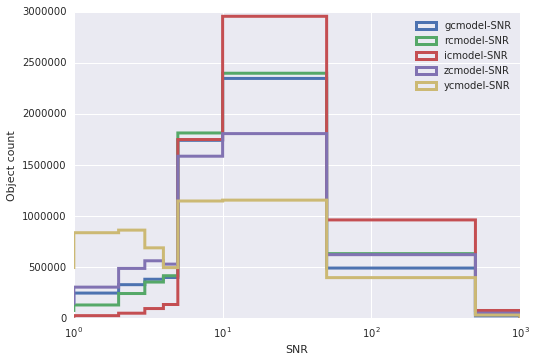

In [6]:
# add SNR columns to the forced catalog.
HSCdata['GAMA15H_forced'], SNCols= addSNR(HSCdata['GAMA15H_forced'])

### Estimate 5$\sigma$ depth 

#### Method 1: Javi's

In [7]:
import flatmaps as fm
flatSkyGrid= fm.FlatMapInfo([212.5,222.],[-2.,2.], dx=0.057,dy=0.057)

In [8]:
flatmaps= {}
for key in HSCdata:  # for both the forced data and the randoms.
    flatmaps[key]=flatSkyGrid.pos2pix(HSCdata[key]['ra'], HSCdata[key]['dec'])

In [9]:
# code from Javier: /global/projecta/projectdirs/lsst/groups/LSS/DC1/scripts/map_utils.py
# creates 5sigma depth HEALPix maps
def binned_statistic(x, values, func, nbins, range):
    '''The usage is approximately the same as the scipy one
    from https://stackoverflow.com/questions/26783719/effic
    iently-get-indices-of-histogram-bins-in-python'''
    from scipy.sparse import csr_matrix
    r0, r1 = range
    mask = (x > r0) &  (x < r1)
    x = x[mask]
    values = values[mask]
    N = len(values)
    digitized = (float(nbins) / (r1-r0) * (x-r0)).astype(int)
    S = csr_matrix((values, [digitized, np.arange(N)]), shape=(nbins, N))
    return np.array([func(group) for group in np.split(S.data, S.indptr[1:-1])])

def depth_map_snr_nonHP(ra,dec,mags,snr, flatSkyGrid):
    # not based on healpix ***
    good = np.logical_or(np.logical_not(np.isnan(ra)),np.logical_not(np.isnan(dec)))
    pix_nums = np.array(flatSkyGrid.pos2pix(ra, dec))
    
    map_out = np.zeros(flatSkyGrid.get_size())
    map_var_out = np.zeros(flatSkyGrid.get_size())
    #Binned statistic 2d is awfully slow (because it doesn't use the fact that all bins are equal width
    #median_snr, xed, _, _ = binned_statistic_2d(mags,pix_nums,snr,statistic='median',bins=(50,12*nside**2),
    #                                           range=[(20,30),(0,12*nside**2)])
    #bin_centers = 0.5*xed[1:]+0.5*xed[:-1]
    #depth = bin_centers[np.argmin(np.fabs(median_snr-5),axis=0)]
    
    bin_centers = np.linspace(22+6/30.,28-6/30.,30.)
    for px in np.unique(pix_nums):
        mask = px==pix_nums
        if np.count_nonzero(mask)>0:
            median_snr = binned_statistic(mags[mask],snr[mask],np.nanmedian, nbins=30, range=(22,28))
            std_snr = binned_statistic(mags[mask],snr[mask],np.nanstd, nbins=30, range=(22,28))
            
            mask2 = np.isnan(median_snr)==False
            if np.count_nonzero(mask2)>0:
                depth = bin_centers[mask2][np.argmin(np.fabs(median_snr[mask2]-5.))]
                std = std_snr[np.argmin(np.fabs(median_snr[mask2]-5.))]
                
                map_out[px]=depth
                map_var_out[px]= std
            else:
                map_out[px]=0
                map_var_out[px]= 0
        else:
            map_out[px]=0.
            map_var_out[px]= 0
    return map_out, map_var_out

In [10]:
HSCField= 'GAMA15H_forced'
bands= ['g', 'r', 'i', 'z', 'y']

In [11]:
depthMap, depthMap_var= {}, {}

In [12]:
# create the 5sigma depth maps for each filter, using cmodel mags. plot skymaps + cartview.
methodTag= 'Javis'
depthMap[methodTag], depthMap_var[methodTag]= {}, {}

for band in bands:
    key= '%scmodel'%band
    out= depth_map_snr_nonHP(ra= HSCdata[HSCField]['ra'], dec= HSCdata[HSCField]['dec'],
                             mags= HSCdata[HSCField]['%s_mag'%key],
                             snr= HSCdata[HSCField]['%s-SNR'%key],
                             flatSkyGrid= flatSkyGrid)
    depthMap[methodTag][band], depthMap_var[methodTag][band]= out

/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


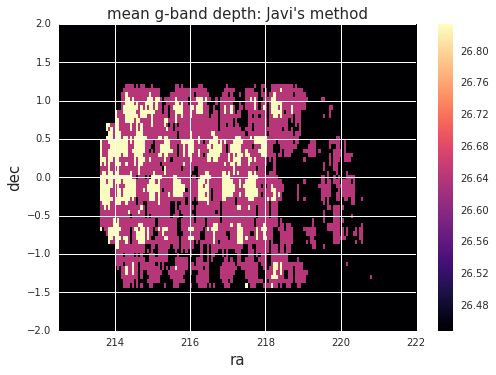

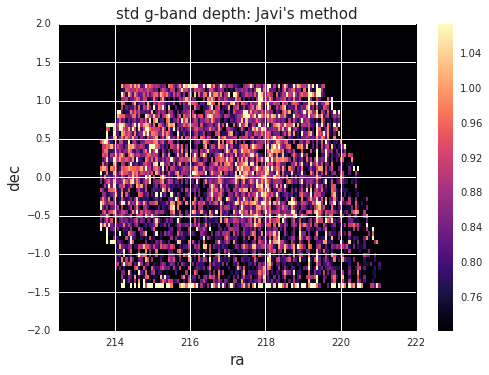

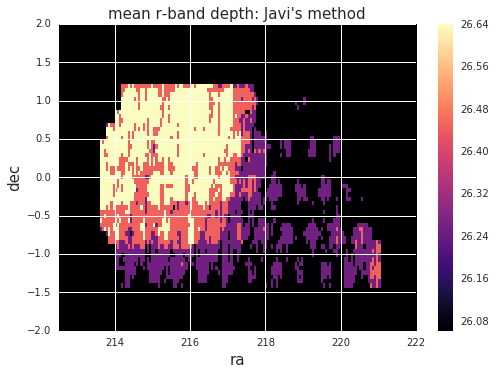

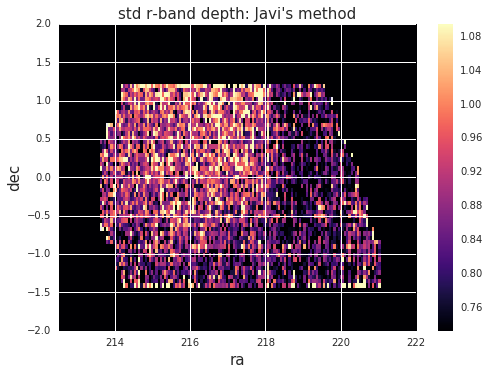

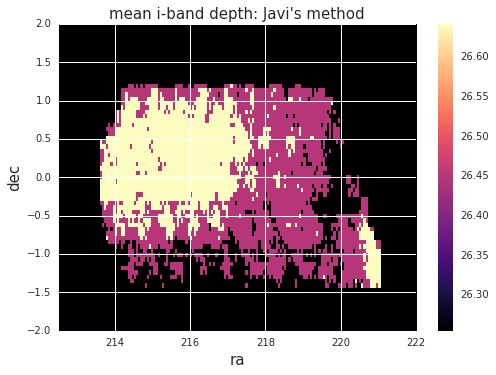

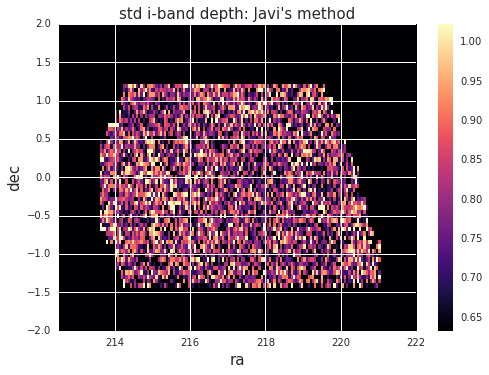

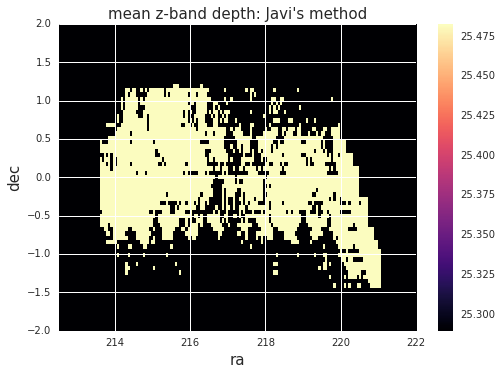

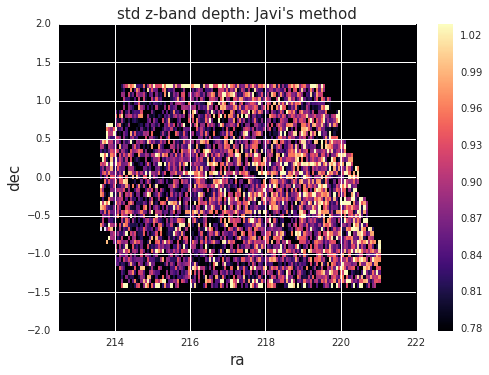

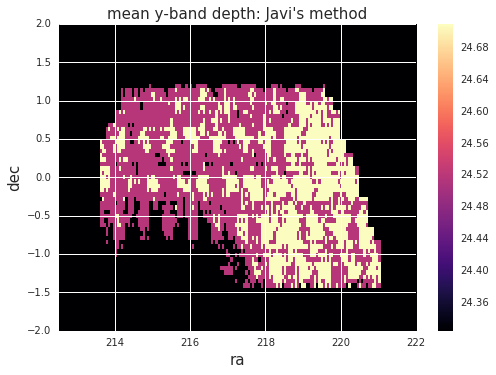

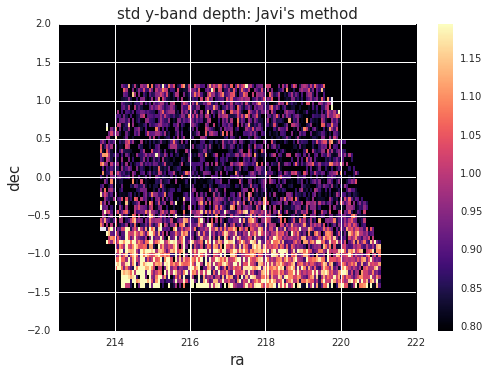

In [13]:
for band in bands:
    flatSkyGrid.view_map(depthMap[methodTag][band], posColorbar= True, title= "mean %s-band depth: Javi's method"%band,
                         xlabel='ra', ylabel='dec')
    flatSkyGrid.view_map(depthMap_var[methodTag][band], posColorbar= True, title= "std %s-band depth: Javi's method"%band,
                         xlabel='ra', ylabel='dec')

### Method 2: 
Bin 5*flux_error for all galaxies in each pixel.

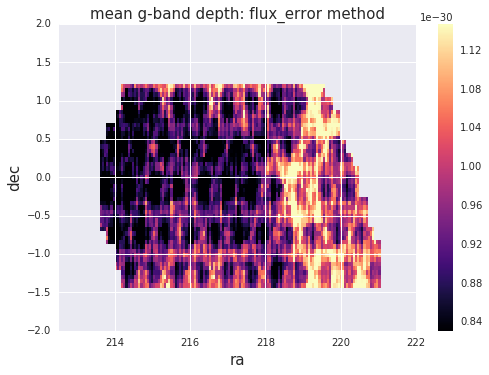

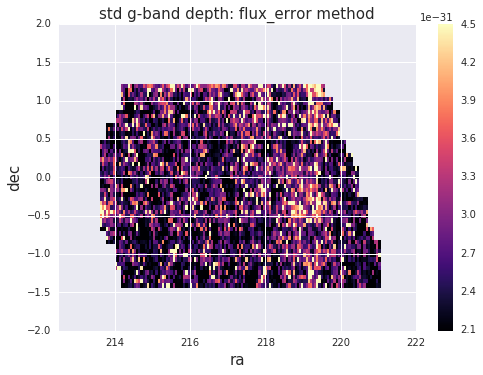

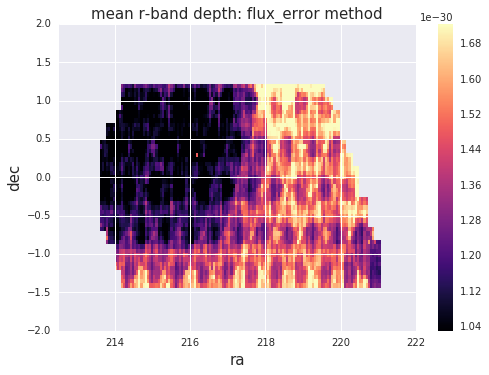

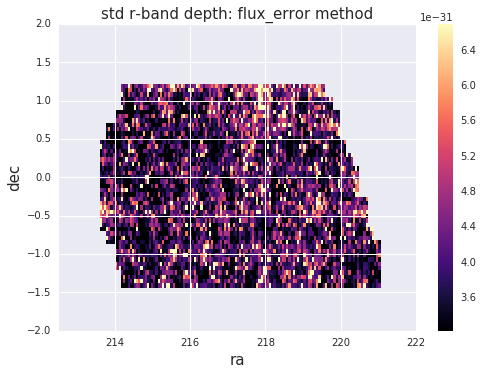

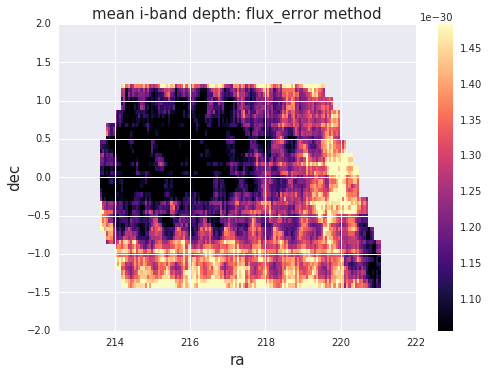

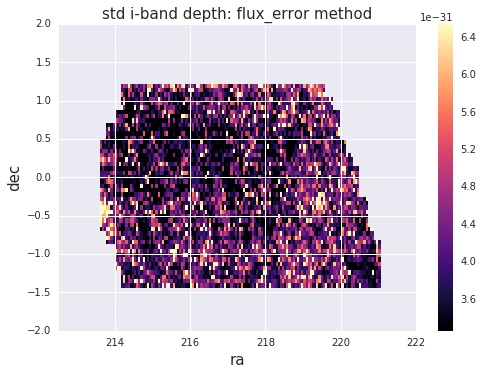

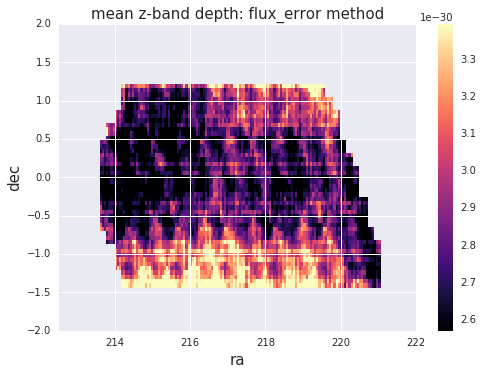

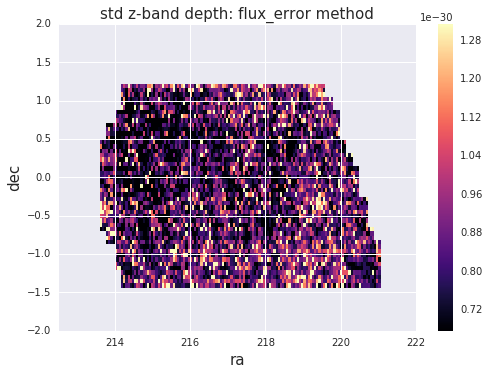

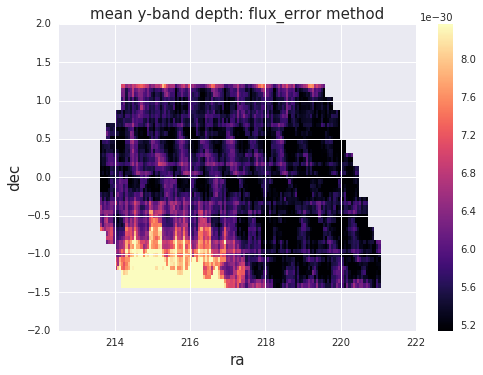

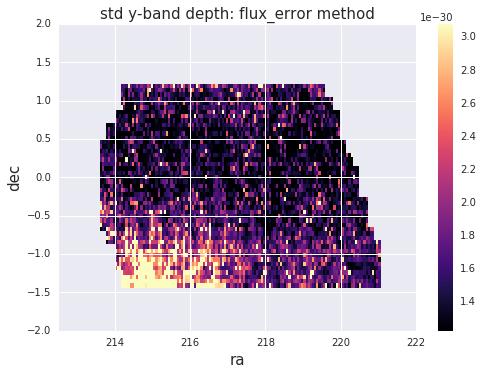

In [14]:
methodTag= 'FluxErr'
depthMap[methodTag], depthMap_var[methodTag]= {}, {}

HSCDataKey= 'GAMA15H_forced'

for band in bands:
    
    out= createMeanStdMaps(ra= HSCdata[HSCDataKey]['ra'], dec= HSCdata[HSCDataKey]['dec'],
                           quantity= 5.*HSCdata[HSCDataKey]['%scmodel_flux_err'%band],
                           flatSkyGrid= flatSkyGrid,
                           plotMaps= True, quantityName= '%s-band depth: flux_error method'%band)
    depthMap[methodTag][band], dontcare= out
    

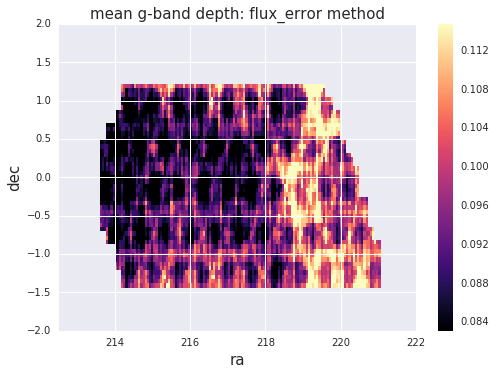

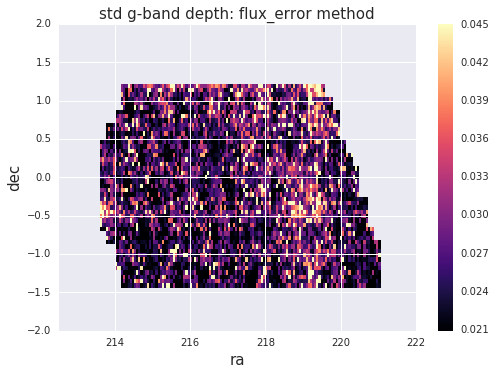

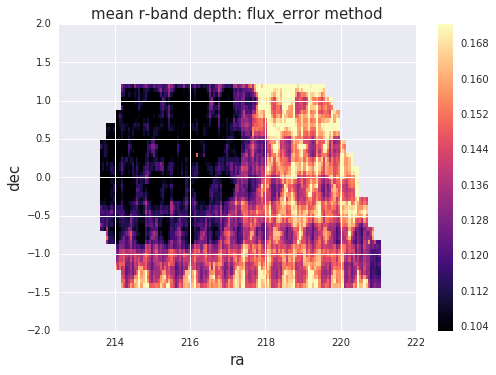

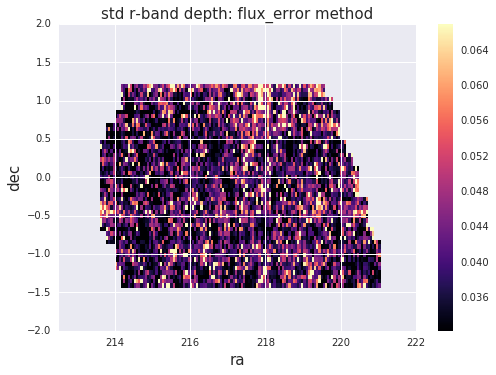

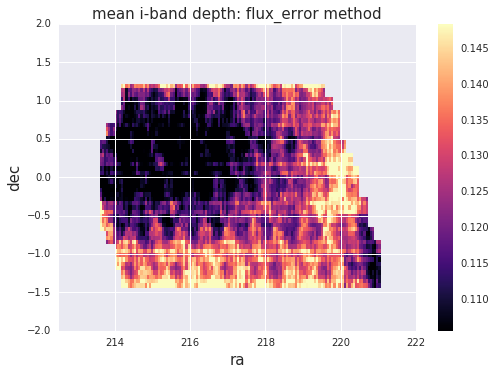

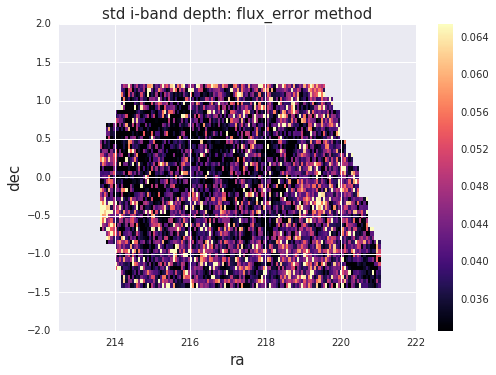

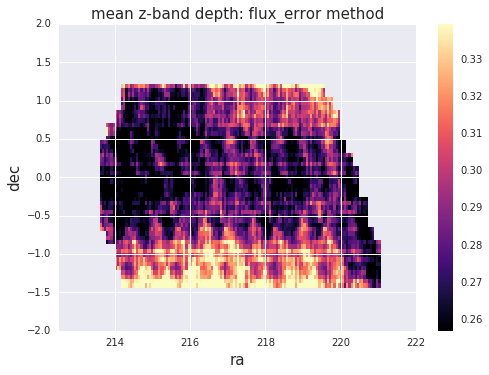

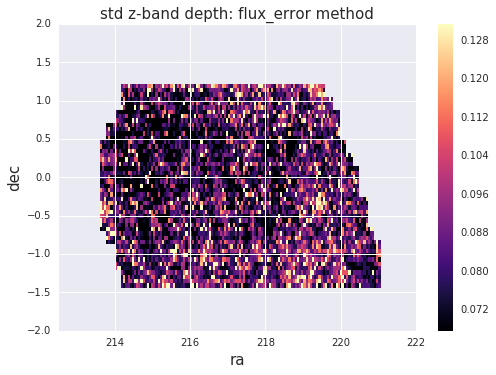

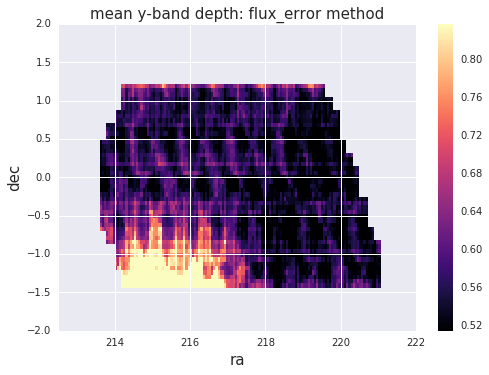

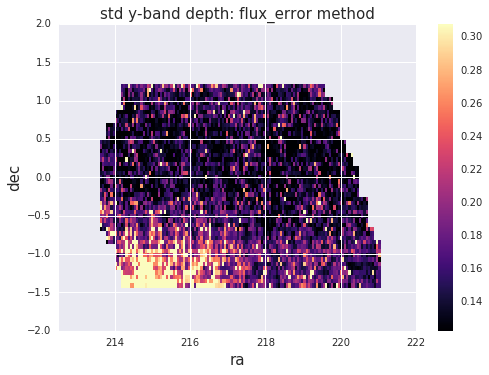

In [15]:
for band in bands:
    quantity= 10.**(23+6)*5.*HSCdata[HSCDataKey]['%scmodel_flux_err'%band]
    quanity= -2.5*np.log10(quantity)+23.9
    out= createMeanStdMaps(ra= HSCdata[HSCDataKey]['ra'], dec= HSCdata[HSCDataKey]['dec'],
                           quantity= quantity, #5.*HSCdata[HSCDataKey]['%scmodel_flux_err'%band],
                           flatSkyGrid= flatSkyGrid,
                           plotMaps= True, quantityName= '%s-band depth: flux_error method'%band)
    dontcare, depthMap_var[methodTag][band]= out
    

In [16]:
# convert from fluxes to mags
for band in bands:
    # convert from erg .. to uJy
    depthMap[methodTag][band]= 10.**(23+6)*depthMap[methodTag][band]
    #depthMap_var[methodTag][band]= 10.**(23+6)*depthMap_var[methodTag][band]

    ind= np.array(np.where(np.isnan(depthMap[methodTag][band])!=True)[0])
    
    depthMap[methodTag][band][ind]= -2.5*np.log10(depthMap[methodTag][band][ind])+23.9

    #ind= np.where(np.isnan(depthMap_var[methodTag][band])!=True)[0]
    #depthMap_var[methodTag][band][ind]= -2.5*np.log10(depthMap_var[methodTag][band][ind])+23.9
    #depthMap_var[methodTag][band]/=depthMap[methodTag][band]

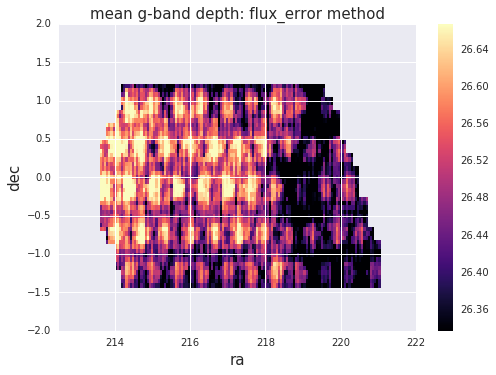

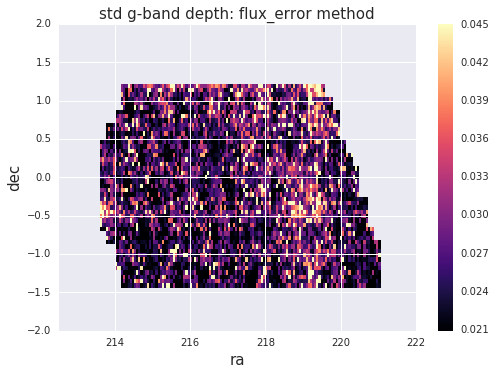

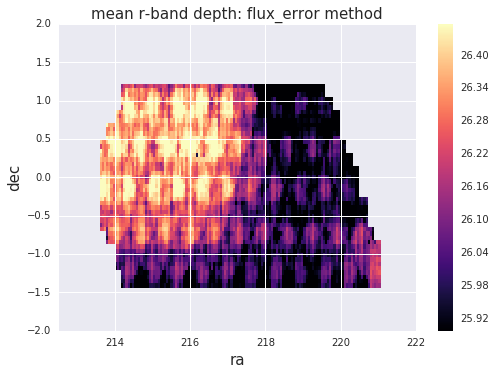

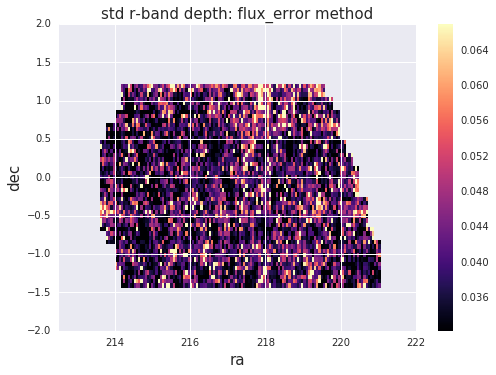

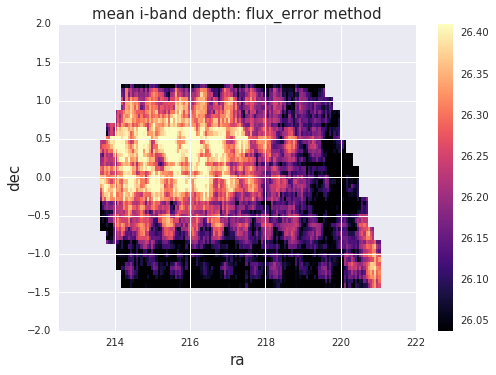

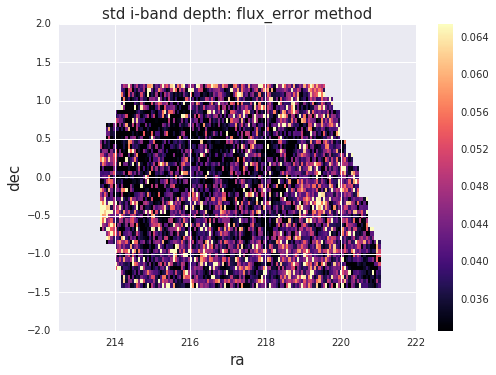

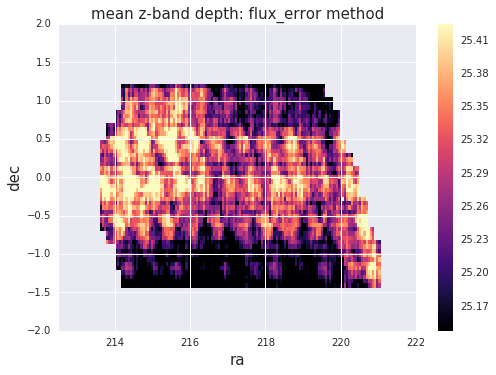

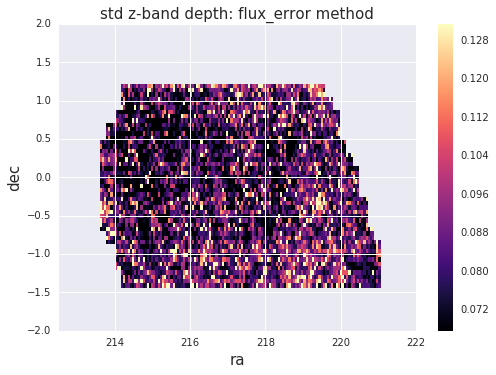

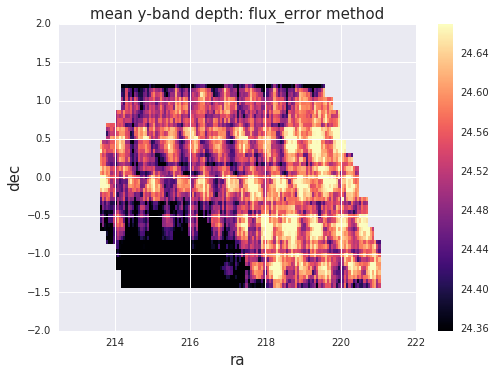

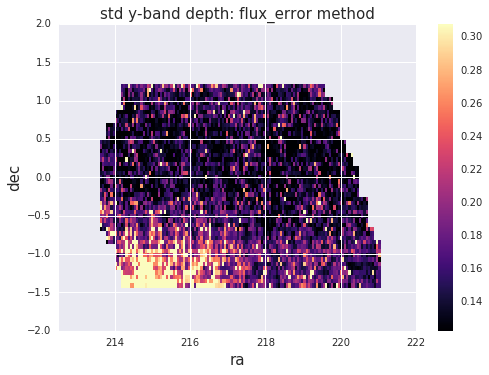

In [17]:
for band in bands:
    flatSkyGrid.view_map(depthMap[methodTag][band], posColorbar= True, title= 'mean %s-band depth: flux_error method'%band,
                         xlabel='ra', ylabel='dec')
    flatSkyGrid.view_map(depthMap_var[methodTag][band], posColorbar= True, title= 'std %s-band depth: flux_error method'%band,
                         xlabel='ra', ylabel='dec')

### Method 3: 
Using the random sky_std as described here: https://hsc-release.mtk.nao.ac.jp/doc/index.php/random-points-for-dr1/

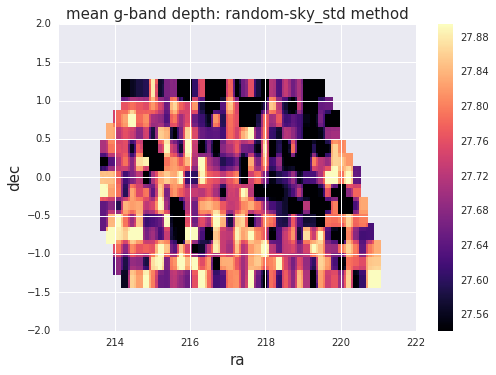

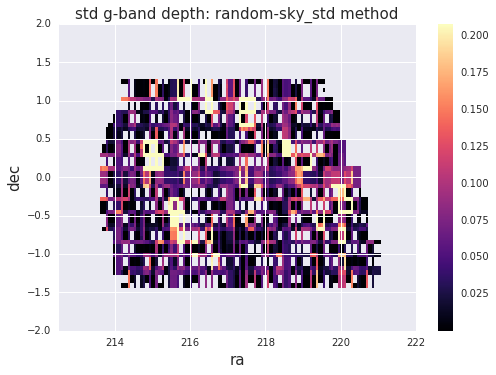

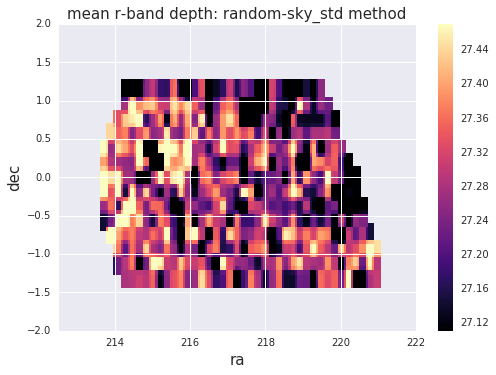

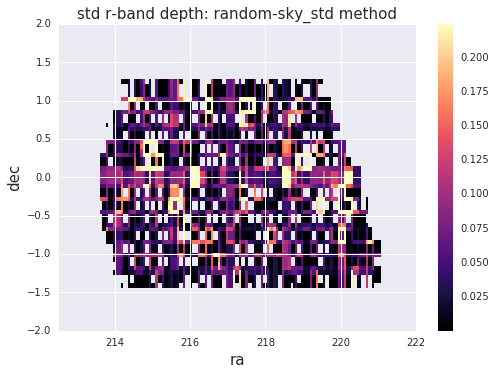

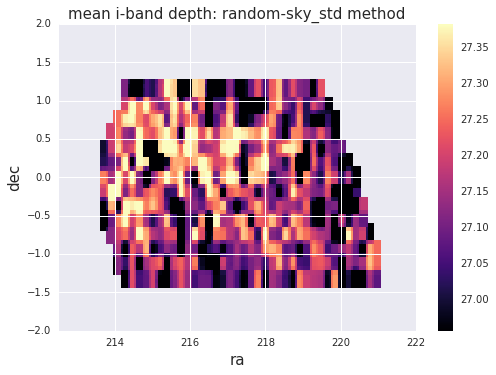

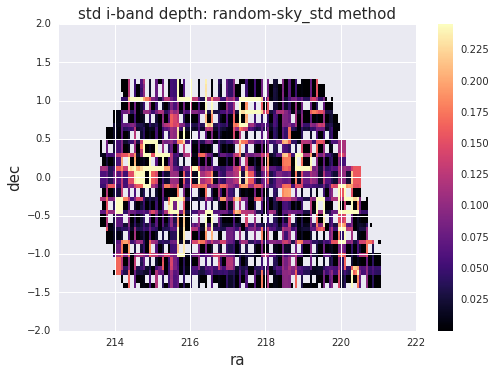

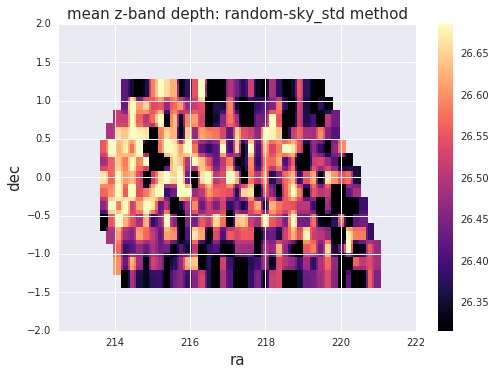

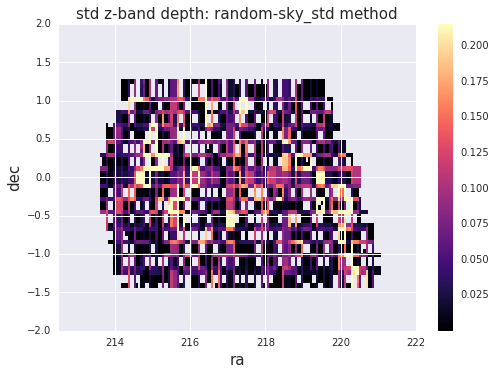

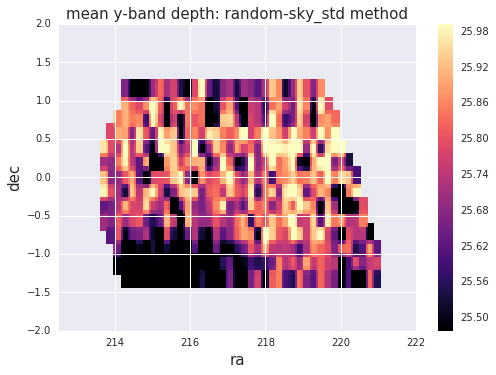

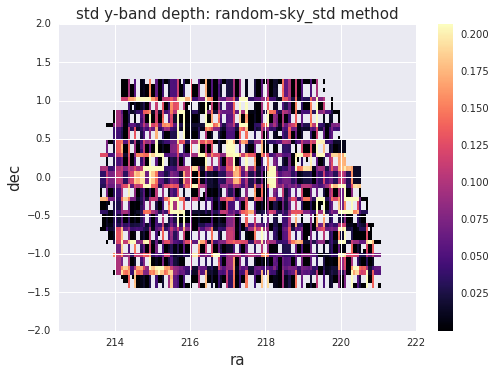

In [18]:
 HSCDataKey= 'GAMA15H_random'

methodTag= 'RandomSkyStd'
depthMap[methodTag], depthMap_var[methodTag]= {}, {}

for band in bands:
    out= createMeanStdMaps(HSCdata[HSCDataKey]['ra'], HSCdata[HSCDataKey]['dec'],
                           quantity= -2.5*np.log10(HSCdata[HSCDataKey]['%ssky_std'%band])+27.0,
                           flatSkyGrid= flatSkyGrid,
                           plotMaps= True, quantityName= '%s-band depth: random-sky_std method'%band)
    depthMap[methodTag][band], depthMap_var[methodTag][band]= out


#### Save data

In [19]:
outputDir= 'maps/'

In [20]:
for band in bands:
    for methodTag in depthMap:
        filename= 'depthMap_%s-band_%sMethod'%(band, methodTag)
        flatSkyGrid.write_flat_map(outputDir+filename, depthMap[methodTag][band])
        print 'Wrote ', filename
        
        filename= 'depthMap_std_%s-band_%sMethod'%(band, methodTag)
        flatSkyGrid.write_flat_map(outputDir+filename, depthMap_var[methodTag][band])
        print 'Wrote ', filename

Wrote  depthMap_g-band_FluxErrMethod
Wrote  depthMap_std_g-band_FluxErrMethod
Wrote  depthMap_g-band_RandomSkyStdMethod
Wrote  depthMap_std_g-band_RandomSkyStdMethod
Wrote  depthMap_g-band_JavisMethod
Wrote  depthMap_std_g-band_JavisMethod
Wrote  depthMap_r-band_FluxErrMethod
Wrote  depthMap_std_r-band_FluxErrMethod
Wrote  depthMap_r-band_RandomSkyStdMethod
Wrote  depthMap_std_r-band_RandomSkyStdMethod
Wrote  depthMap_r-band_JavisMethod
Wrote  depthMap_std_r-band_JavisMethod
Wrote  depthMap_i-band_FluxErrMethod
Wrote  depthMap_std_i-band_FluxErrMethod
Wrote  depthMap_i-band_RandomSkyStdMethod
Wrote  depthMap_std_i-band_RandomSkyStdMethod
Wrote  depthMap_i-band_JavisMethod
Wrote  depthMap_std_i-band_JavisMethod
Wrote  depthMap_z-band_FluxErrMethod
Wrote  depthMap_std_z-band_FluxErrMethod
Wrote  depthMap_z-band_RandomSkyStdMethod
Wrote  depthMap_std_z-band_RandomSkyStdMethod
Wrote  depthMap_z-band_JavisMethod
Wrote  depthMap_std_z-band_JavisMethod
Wrote  depthMap_y-band_FluxErrMethod
Wro